In [1]:

import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux,get_Max_Phase_Speed
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans
import morph_geom_lib as mgl

import models.simple_depth_morph_models as simple_models

from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

rc('animation', html='html5')

%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext cython
plt.style.use(['default'])

Grid dx = 1.0
Grid nx = 300


Text(0, 0.5, 'Depth (m)')

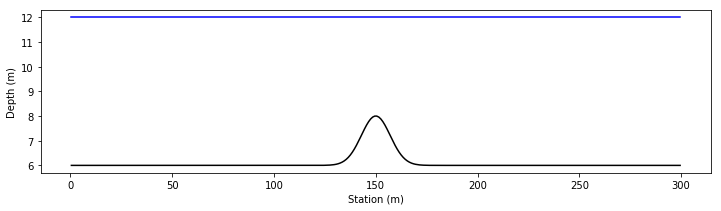

In [2]:
# Set up the constants
a=0.001
b=3.0
Q=10.0
nP=0.4
xcentre = 150.  # Centre of hum
h0 = 6.0        # Height of the dune
s= 12.0            # Datum
beta = 0.01
nx=300
x = pyclaw.Dimension(0.0,300.0,nx,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,1)
xc = state.grid.x.centers
dx = state.grid.delta[0]
print('Grid dx = {0}'.format(dx))
print('Grid nx = {0}'.format(len(xc)))

# Set up the bathymetry
z = np.zeros(nx)

# Eq 66
z = np.array([(h0 + 2.0*math.exp(-beta*(xp-xcentre)**2)) for xp in xc])
zc = z.copy()
z0 = zc.copy() 
fig = plt.figure(figsize=(12, 3))
surf = np.ones(nx) * s
plt.plot(xc, surf, 'b')
plt.plot(xc, zc,'k')

plt.xlabel('Station (m)')
plt.ylabel('Depth (m)')

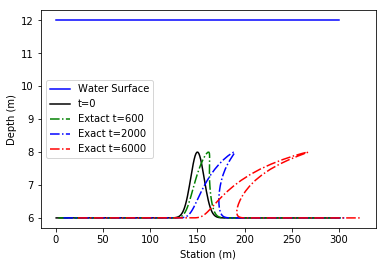

In [3]:
from schemes.weno import get_exact_solution
x_600, z_a600 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,600.)
x_2000, z_a2000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,2000.)
x_6000, z_a6000 = get_exact_solution(z0,xc, 0.4,s,a,b,10.,6000.)
np.shape(x_600),np.shape(z_a600)

plt.plot(xc, surf, 'b', label='Water Surface')
plt.plot(xc,z0, label='t=0', color='k')

plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')

plt.xlabel('Station (m)')
plt.ylabel('Depth (m)')


plt.legend()

### MacCormack - Avalanched and Smoothed

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Zc = 300
Max qbedload = 0.015566625246422628


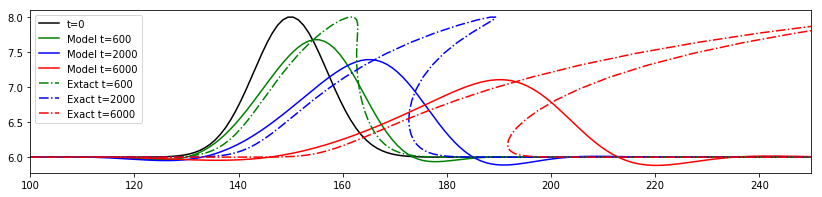

In [4]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

model = simple_models.SimpleHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = simple_models.MacCormackModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = True)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h0


verts = model._verts
name = 'MacCormackModel_avalanche_smoothed'
np.save('_output/{0}_verts.npy'.format(name),verts)

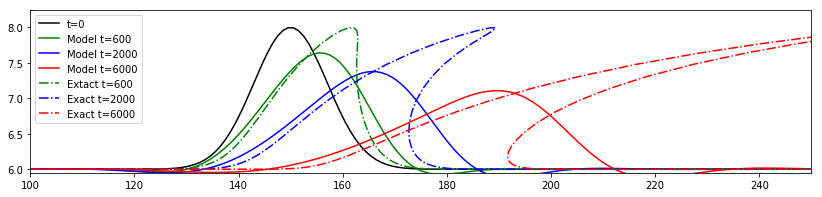

In [61]:
name = 'MacCormackModel_avalanche_smoothed'
verts = np.load('_output/{0}_verts.npy'.format(name))

fig = plt.figure(figsize=(14, 3))
plt.xlim(100,250)
plt.ylim(5.95, 8.25)
z600 = verts[5,:,1]
z2000= verts[19,:,1]
z6000= verts[verts.shape[0]-1,:,1]

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, z6000, label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

### MacCormack - No Avalanched and Not Smoothed

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Zc = 300
Max qbedload = 0.015566625246422628


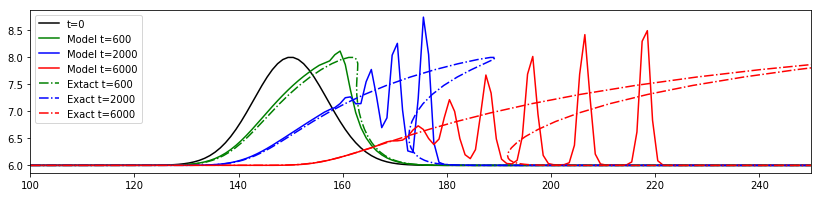

In [5]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

model = simple_models.SimpleHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = simple_models.MacCormackModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h0

verts = model._verts
name = 'MacCormackModel_NO_avalanche_No_smoothed'
np.save('_output/{0}_verts.npy'.format(name),verts)


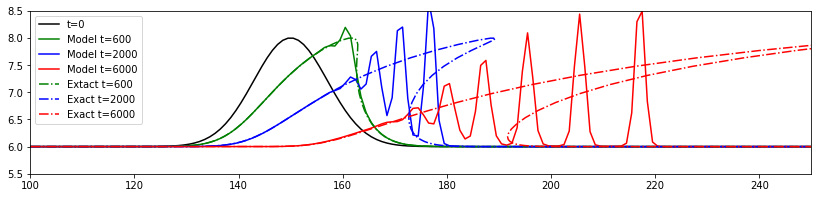

In [62]:
name = 'MacCormackModel_NO_avalanche_No_smoothed'
verts = np.load('_output/{0}_verts.npy'.format(name))

fig = plt.figure(figsize=(14, 3))
plt.xlim(100,250)
plt.ylim(5.5, 8.5)
z600 = verts[5,:,1]
z2000= verts[19,:,1]
z6000= verts[verts.shape[0]-1,:,1]

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, z6000, label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

### MacCormack - Avalanched and Not Smoothed

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Zc = 300
Max qbedload = 0.015566625246422628


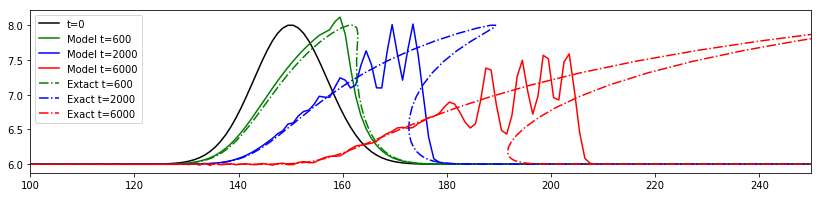

In [6]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4


model = simple_models.SimpleHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = simple_models.MacCormackModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h0

verts = model._verts
name = 'MacCormackModel_avalanche_No_smoothed'
np.save('_output/{0}_verts.npy'.format(name),verts)

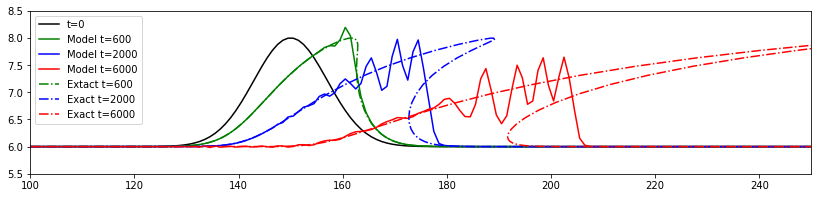

In [63]:
name = 'MacCormackModel_avalanche_No_smoothed'
verts = np.load('_output/{0}_verts.npy'.format(name))

fig = plt.figure(figsize=(14, 3))
plt.xlim(100,250)
plt.ylim(5.5, 8.5)
z600 = verts[5,:,1]
z2000= verts[19,:,1]
z6000= verts[verts.shape[0]-1,:,1]

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, z6000, label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

### MacCormack - Not Avalanched and Smoothed

In [36]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4


model = simple_models.SimpleHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = simple_models.MacCormackModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = True)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h0

verts = model._verts
name = 'MacCormackModel_no_avalanche_smoothed'
np.save('_output/{0}_verts.npy'.format(name),verts)

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Zc = 300
Max qbedload = 0.015566625246422628


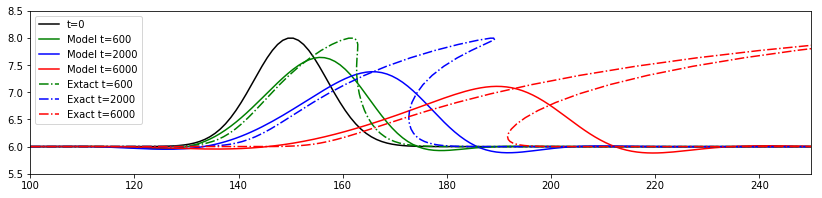

In [64]:
verts = model._verts
name = 'MacCormackModel_no_avalanche_smoothed'
verts = np.load('_output/{0}_verts.npy'.format(name))


fig = plt.figure(figsize=(14, 3))
plt.xlim(100,250)
plt.ylim(5.5, 8.5)
z600 = verts[5,:,1]
z2000= verts[19,:,1]
z6000= verts[verts.shape[0]-1,:,1]

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, z6000, label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

### Upwinded - No Avalanched and No Smoothed

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Zc = 300
Max qbedload = 0.015566625246422628


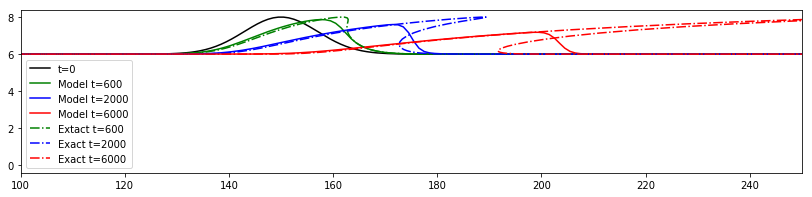

In [12]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'dune_5_q_{0}_h_{1}_TVD_WENO'.format(Q,'12')

model = simple_models.SimpleHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = simple_models.EulerUpwindModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h0


verts = model._verts
name = 'Upwind_noavalanche_nosmoothed'
np.save('_output/{0}_verts.npy'.format(name),verts)

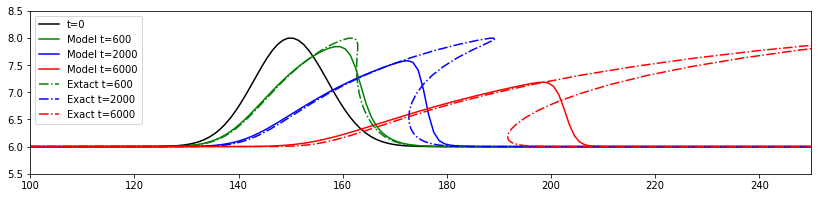

In [65]:
verts = model._verts
name = 'Upwind_noavalanche_nosmoothed'
verts = np.load('_output/{0}_verts.npy'.format(name))


fig = plt.figure(figsize=(14, 3))
plt.xlim(100,250)
plt.ylim(5.5, 8.5)
z600 = verts[5,:,1]
z2000= verts[19,:,1]
z6000= verts[verts.shape[0]-1,:,1]

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, z6000, label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

### TVD - 2nd Order - WENO

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Zc = 300
Max qbedload = 0.015566625246422628


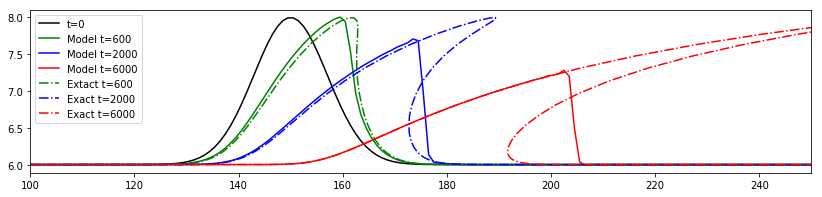

In [16]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'dune_5_q_{0}_h_{1}_TVD_WENO'.format(Q,'12')

model = simple_models.SimpleHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = simple_models.TVD2ndWenoModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h0

name = 'tvdweno_noavalanche_nosmoothed'
verts = model._verts
np.save('_output/{0}_verts.npy'.format(name),verts)

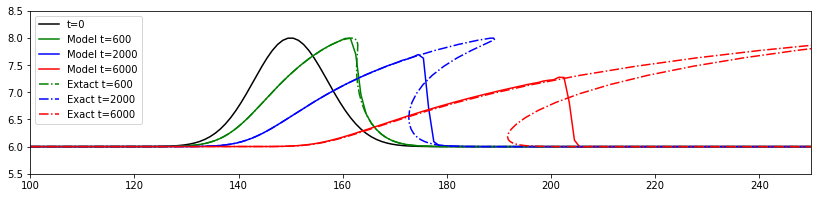

In [66]:
name = 'tvdweno_noavalanche_nosmoothed'
verts = np.load('_output/{0}_verts.npy'.format(name))

fig = plt.figure(figsize=(14, 3))
plt.xlim(100,250)
plt.ylim(5.5, 8.5)
z600 = verts[5,:,1]
z2000= verts[19,:,1]
z6000= verts[verts.shape[0]-1,:,1]

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, z6000, label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

### Euler First Order - WENO

 Starting simulation....
Number of time steps: 1000.0 mins
Grid dx = 1.0
Grid nx = 300
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Zc = 300
Max qbedload = 0.015566625246422628


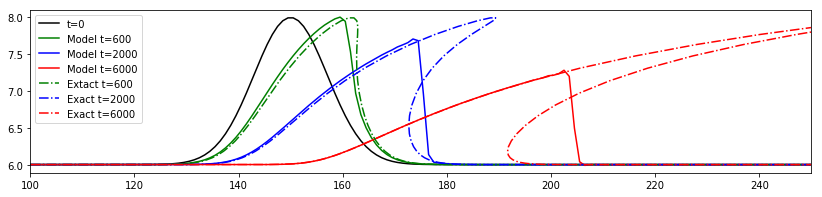

In [17]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 6000 # Runtime in seconds
dt = 0.1 # Time step size (s)
extractionTime = 100.
nt = int(simTime/dt)  # Number of time st


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

run_name = 'dune_5_q_{0}_h_{1}_TVD_WENO'.format(Q,'12')

model = simple_models.SimpleHydroMorphologicalModel()
#--------------------------------
# Set up the geometry
#--------------------------------
x0 = xc.copy()
zc = z0.copy()
nx = len(xc)


model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(Q, 12.)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
morph_model = simple_models.EulerWenoModel()

model.setup_morpho_model( morph_model, 
                           useAvalanche = False, 
                           useSmoother = False)
#model.set_scale_factor(1)
#model.use_modifier()
#model.use_periodic_reattachment()

zc, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h0


verts = model._verts
name = 'eulerweno_noavalanche_nosmoothed'
np.save('_output/{0}_verts.npy'.format(name),verts)

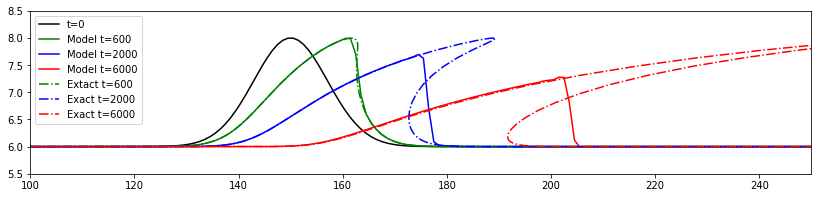

In [67]:
name = 'eulerweno_noavalanche_nosmoothed'
verts = np.load('_output/{0}_verts.npy'.format(name))

fig = plt.figure(figsize=(14, 3))
plt.xlim(100,250)
plt.ylim(5.5, 8.5)
z600 = verts[5,:,1]
z2000= verts[19,:,1]
z6000= verts[verts.shape[0]-1,:,1]

plt.plot(xc,z0, label='t=0', color='k')
plt.plot(xc, z600,label='Model t=600',color='g')
plt.plot(xc, z2000,label='Model t=2000',color='b')
plt.plot(xc, z6000, label='Model t=6000',color='r')


plt.plot(x_600, z_a600, 'g-.', label='Extact t=600',)
plt.plot(x_2000, z_a2000,'b-.', label='Exact t=2000')
plt.plot(x_6000, z_a6000,'r-.', label='Exact t=6000')
plt.legend()

In [27]:
verts.shape[0]

59

In [48]:
6000/59

101.69491525423729

In [51]:
600/101.7


5.899705014749262